In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
# Hyperparameters
batch_size = 64
learning_rate = 1e-4
num_epochs = 10
timesteps = 1000
beta_start = 1e-4
beta_end = 0.02

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


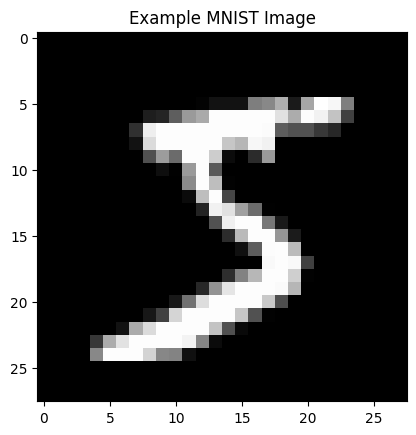

In [8]:
# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = x_train[..., tf.newaxis]  # Add channel dimension for grayscale
x_test = x_test[..., tf.newaxis]

# Print data shapes
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# Display an example image from the training set
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.title("Example MNIST Image")
plt.show()


In [9]:
# Define the model using the functional API
inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape((28, 28, 1))(outputs)

model = tf.keras.Model(inputs, outputs)

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       201,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,984,528 (99.12 MB)

 Trainable params: 25,984,528 (99.12 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define betas and alphas
betas = tf.linspace(beta_start, beta_end, timesteps)
alphas = 1 - betas
alphas_bar = tf.math.cumprod(alphas)

# Print beta and alpha shapes
print(f"betas shape: {betas.shape}")
print(f"alphas shape: {alphas.shape}")
print(f"alphas_bar shape: {alphas_bar.shape}")


betas shape: (1000,)
alphas shape: (1000,)
alphas_bar shape: (1000,)


In [11]:
# Function to add noise to the data
def add_noise(x, t):
    noise = tf.random.normal(shape=tf.shape(x))
    alpha_bar = tf.gather(alphas_bar, t)
    return tf.sqrt(alpha_bar)[..., None, None, None] * x + tf.sqrt(1 - alpha_bar)[..., None, None, None] * noise, noise


In [14]:
# Function to calculate the loss
def calculate_loss(x, t, x_noisy, true_noise):
    predicted_noise = model(x_noisy)
    loss = tf.keras.losses.MeanSquaredError()(predicted_noise, true_noise)
    return loss


In [15]:
# Training loop
for epoch in range(num_epochs):
    for batch_idx, data in enumerate(tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size, drop_remainder=True)):  
        t = tf.random.uniform(shape=[data.shape[0]], minval=0, maxval=timesteps, dtype=tf.int32)
        x_noisy, true_noise = add_noise(data, t)

        with tf.GradientTape() as tape:
            loss = calculate_loss(data, t, x_noisy, true_noise)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.numpy()}")


Epoch 1, Batch 0, Loss: 0.99075847864151
Epoch 1, Batch 100, Loss: 0.9905893206596375
Epoch 1, Batch 200, Loss: 0.980884850025177
Epoch 1, Batch 300, Loss: 0.9955935478210449
Epoch 1, Batch 400, Loss: 0.993279755115509
Epoch 1, Batch 500, Loss: 0.9876493215560913
Epoch 1, Batch 600, Loss: 0.9888930320739746
Epoch 1, Batch 700, Loss: 0.9889037609100342
Epoch 1, Batch 800, Loss: 0.9793212413787842
Epoch 1, Batch 900, Loss: 0.9915712475776672


2024-07-12 06:08:38.201066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Batch 0, Loss: 0.9878690242767334
Epoch 2, Batch 100, Loss: 0.9749526977539062
Epoch 2, Batch 200, Loss: 0.9838546514511108
Epoch 2, Batch 300, Loss: 0.9862492084503174
Epoch 2, Batch 400, Loss: 0.9916733503341675
Epoch 2, Batch 500, Loss: 0.99181067943573
Epoch 2, Batch 600, Loss: 0.9811180233955383
Epoch 2, Batch 700, Loss: 0.9854148030281067
Epoch 2, Batch 800, Loss: 0.9839222431182861
Epoch 2, Batch 900, Loss: 1.002243161201477


2024-07-12 06:09:12.950036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3, Batch 0, Loss: 0.9838994741439819
Epoch 3, Batch 100, Loss: 0.9925750494003296
Epoch 3, Batch 200, Loss: 0.982549786567688
Epoch 3, Batch 300, Loss: 0.995786726474762
Epoch 3, Batch 400, Loss: 0.9889101386070251
Epoch 3, Batch 500, Loss: 0.9870971441268921
Epoch 3, Batch 600, Loss: 0.9994453191757202
Epoch 3, Batch 700, Loss: 0.9801462888717651
Epoch 3, Batch 800, Loss: 0.987266480922699
Epoch 3, Batch 900, Loss: 0.9881068468093872


2024-07-12 06:09:48.167655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Batch 0, Loss: 0.9822548031806946
Epoch 4, Batch 100, Loss: 0.9941986799240112
Epoch 4, Batch 200, Loss: 0.9894078373908997
Epoch 4, Batch 300, Loss: 0.9822837710380554
Epoch 4, Batch 400, Loss: 0.990215003490448
Epoch 4, Batch 500, Loss: 0.9940966963768005
Epoch 4, Batch 600, Loss: 0.9898557066917419
Epoch 4, Batch 700, Loss: 0.9878535270690918
Epoch 4, Batch 800, Loss: 0.9852458238601685
Epoch 4, Batch 900, Loss: 0.9871306419372559


2024-07-12 06:10:24.082542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5, Batch 0, Loss: 0.9928327202796936
Epoch 5, Batch 100, Loss: 0.994915246963501
Epoch 5, Batch 200, Loss: 0.9940791130065918
Epoch 5, Batch 300, Loss: 0.9859743118286133
Epoch 5, Batch 400, Loss: 0.9868466258049011
Epoch 5, Batch 500, Loss: 0.9828519821166992
Epoch 5, Batch 600, Loss: 0.979320764541626
Epoch 5, Batch 700, Loss: 0.9851030111312866
Epoch 5, Batch 800, Loss: 0.9909906387329102
Epoch 5, Batch 900, Loss: 0.9890550971031189


2024-07-12 06:11:05.142534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6, Batch 0, Loss: 0.9978724122047424
Epoch 6, Batch 100, Loss: 0.9968293905258179
Epoch 6, Batch 200, Loss: 0.9910501837730408
Epoch 6, Batch 300, Loss: 0.990720272064209
Epoch 6, Batch 400, Loss: 0.9850899577140808
Epoch 6, Batch 500, Loss: 0.9797508120536804
Epoch 6, Batch 600, Loss: 0.9783905744552612
Epoch 6, Batch 700, Loss: 0.9847134947776794
Epoch 6, Batch 800, Loss: 0.9941138625144958
Epoch 6, Batch 900, Loss: 0.9925699234008789


2024-07-12 06:11:45.766359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7, Batch 0, Loss: 0.9962725043296814
Epoch 7, Batch 100, Loss: 0.9816263318061829
Epoch 7, Batch 200, Loss: 0.9858183860778809
Epoch 7, Batch 300, Loss: 0.9821012616157532
Epoch 7, Batch 400, Loss: 0.9823539853096008
Epoch 7, Batch 500, Loss: 0.9801406860351562
Epoch 7, Batch 600, Loss: 0.9806146621704102
Epoch 7, Batch 700, Loss: 0.9898521304130554
Epoch 7, Batch 800, Loss: 0.9830665588378906
Epoch 7, Batch 900, Loss: 0.9852849245071411


2024-07-12 06:12:23.276634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8, Batch 0, Loss: 0.9938425421714783
Epoch 8, Batch 100, Loss: 0.9837610721588135
Epoch 8, Batch 200, Loss: 0.9938707947731018
Epoch 8, Batch 300, Loss: 0.9907231330871582
Epoch 8, Batch 400, Loss: 0.9782527089118958
Epoch 8, Batch 500, Loss: 0.9877962470054626
Epoch 8, Batch 600, Loss: 0.984260618686676
Epoch 8, Batch 700, Loss: 0.9888649582862854
Epoch 8, Batch 800, Loss: 0.9750526547431946
Epoch 8, Batch 900, Loss: 0.9802586436271667


2024-07-12 06:12:58.980455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9, Batch 0, Loss: 0.9951408505439758
Epoch 9, Batch 100, Loss: 0.9830725789070129
Epoch 9, Batch 200, Loss: 0.9834373593330383
Epoch 9, Batch 300, Loss: 0.9905834794044495
Epoch 9, Batch 400, Loss: 0.9912289977073669
Epoch 9, Batch 500, Loss: 0.9842560291290283
Epoch 9, Batch 600, Loss: 0.9855989217758179
Epoch 9, Batch 700, Loss: 0.9872265458106995
Epoch 9, Batch 800, Loss: 0.9946461319923401
Epoch 9, Batch 900, Loss: 0.9815435409545898


2024-07-12 06:13:34.963416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10, Batch 0, Loss: 0.9823659658432007
Epoch 10, Batch 100, Loss: 0.9988861083984375
Epoch 10, Batch 200, Loss: 0.9910761117935181
Epoch 10, Batch 300, Loss: 0.9762443900108337
Epoch 10, Batch 400, Loss: 0.9913364052772522
Epoch 10, Batch 500, Loss: 0.9861183166503906
Epoch 10, Batch 600, Loss: 0.9846216440200806
Epoch 10, Batch 700, Loss: 0.9816276431083679
Epoch 10, Batch 800, Loss: 0.9813628196716309
Epoch 10, Batch 900, Loss: 0.9934846758842468


2024-07-12 06:14:11.448198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Generate images
def generate_images(num_images=10):
    noise = tf.random.normal(shape=[num_images, 28, 28, 1])
    for t in reversed(range(timesteps)):
        predicted_noise = model(noise)
        alpha_bar = tf.gather(alphas_bar, t)
        noise = tf.sqrt(alpha_bar)[..., None, None, None] * noise + tf.sqrt(1 - alpha_bar)[..., None, None, None] * predicted_noise

    images = tf.clip_by_value(noise, 0.0, 1.0)
    return images

# Generate and visualize images
generated_images = generate_images()
print(f"Generated images shape: {generated_images.shape}")
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    axs[i // 5, i % 5].imshow(generated_images[i][..., 0], cmap='gray')
    axs[i // 5, i % 5].axis('off')
plt.show()
